In [1]:
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator, img_to_array, load_img
from tensorflow.keras.backend import clear_session
from tensorflow.keras.callbacks import TensorBoard
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.models import load_model
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import datetime

In [3]:
train_path = './DATASET/TRAIN'
test_path = './DATASET/TEST'

train_datagen = ImageDataGenerator(
      rescale=1./255,
      shear_range=0.2,
      rotation_range=360,
      fill_mode='nearest',
      zoom_range=0.2,
      width_shift_range=0.2,
      height_shift_range=0.2,
      horizontal_flip=True,
      vertical_flip=True
)

validation_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    directory=train_path,
    target_size=(224,224),
    class_mode='categorical',
    batch_size=20,
    color_mode='rgb'
)

validation_generator = validation_datagen.flow_from_directory(
    directory=test_path,
    target_size=(224,224),
    class_mode='categorical',
    batch_size=10,
    color_mode='rgb'
)

Found 1040 images belonging to 13 classes.
Found 130 images belonging to 13 classes.


In [4]:
motives_dict = train_generator.class_indices
print(motives_dict)

{'Batik Bali': 0, 'Batik Betawi': 1, 'Batik Celup': 2, 'Batik Cendrawasih': 3, 'Batik Gentongan (Madura)': 4, 'Batik Kawung': 5, 'Batik Keraton': 6, 'Batik Lasem': 7, 'Batik Megamendung': 8, 'Batik Parang': 9, 'Batik Sekar': 10, 'Batik Sogan': 11, 'Batik Tambal': 12}


In [5]:
clear_session()

base_model = MobileNetV2(
    include_top=False,
    weights='imagenet',
    input_shape=(224, 224, 3),
    alpha=0.75,
    pooling='avg'
)

base_model.trainable = False

model = Sequential([
    base_model,
    Dense(256, activation='relu'),
    Dropout(0.25),
    Dense(13, activation='softmax')
])

model.compile(
    optimizer=Adam(learning_rate=1e-4),
    loss='categorical_crossentropy',
    metrics=['accuracy'],
)

model.summary()

log_dir = "logs/" + 'mobilenet_0.75_256_0.25_adam1e-4_balanced'
# datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = TensorBoard(log_dir=log_dir, histogram_freq=1)

history = model.fit(
    train_generator,
    validation_data=validation_generator,
    steps_per_epoch=1040/20,
    validation_steps=130//10,
    shuffle=True,
    epochs=50,
    callbacks=[tensorboard_callback]
)

model.save('./models/mobilenet_0.75_256_0.25_adam1e-4_balanced.h5')

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
mobilenetv2_0.75_224 (Functi (None, 1280)              1382064   
_________________________________________________________________
dense (Dense)                (None, 256)               327936    
_________________________________________________________________
dropout (Dropout)            (None, 256)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 13)                3341      
Total params: 1,713,341
Trainable params: 331,277
Non-trainable params: 1,382,064
_________________________________________________________________
Epoch 1/50
52/52 [==============================] - 39s 660ms/step - loss: 2.8690 - accuracy: 0.0893 - val_loss: 2.3278 - val_accuracy: 0.2538
Epoch 2/50
52/52 [==============================] - 36s 692ms/step - loss: 2.2792 - accuracy: 0

NameError: name 'mobilenet_model' is not defined

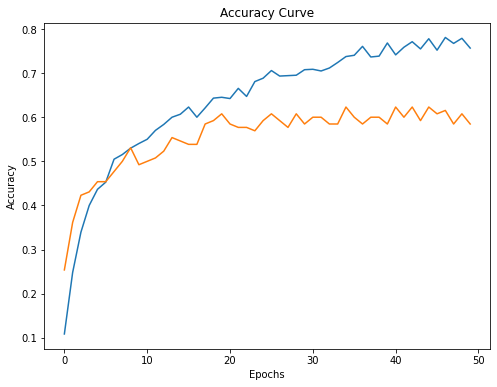

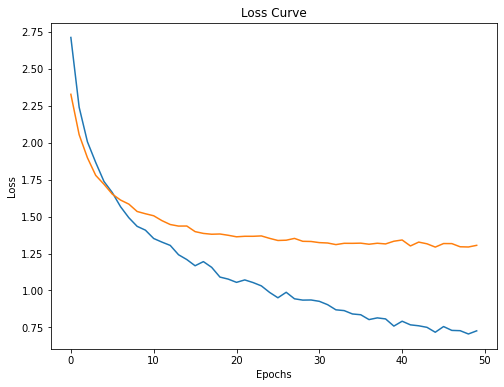

In [6]:
train_acc = history.history['accuracy']
train_loss = history.history['loss']
val_acc = history.history['val_accuracy']
val_loss = history.history['val_loss']

plt.figure(figsize=(8,6))
plt.title('Accuracy Curve')
plt.plot(train_acc, label='Training')
plt.plot(val_acc, label='Validation')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')

plt.figure(figsize=(8,6))
plt.title('Loss Curve')
plt.plot(train_loss, label='Training')
plt.plot(val_loss, label='Validation')
plt.xlabel('Epochs')
plt.ylabel('Loss')

plt.show()

In [9]:
loaded_model = load_model('./models/mobilenet_0.75_256_0.25_adam1e-4_balanced.h5')
loaded_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
mobilenetv2_0.75_224 (Functi (None, 1280)              1382064   
_________________________________________________________________
dense (Dense)                (None, 256)               327936    
_________________________________________________________________
dropout (Dropout)            (None, 256)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 13)                3341      
Total params: 1,713,341
Trainable params: 331,277
Non-trainable params: 1,382,064
_________________________________________________________________


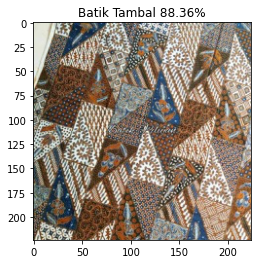

In [84]:
import re

img_path = 'DATASET/TEST/Batik Tambal/89.jpg'
img = load_img(img_path, target_size=(224, 224), grayscale=False)

img_array = img_to_array(img) / 255.0
img_array = tf.expand_dims(img_array, 0)

motives_list = list(motives_dict.keys())
prediction = loaded_model(img_array)
pred_idx = np.argmax(prediction)
pred_motive = motives_list[pred_idx]
pred_confidence = prediction[0][pred_idx] * 100

plt.figure()
plt.title(f'{pred_motive} {pred_confidence:.2f}%')
plt.imshow(img)